In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost.sklearn import XGBClassifier

In [2]:
df = pd.read_csv('churn_data.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


## Initial EDA

In [7]:
df[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']].corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.102411
tenure,0.016567,1.000000,0.247900,0.825880
MonthlyCharges,0.220173,0.247900,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


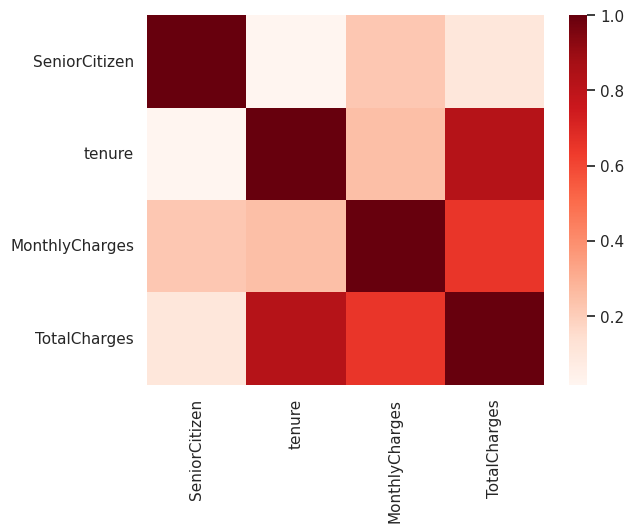

In [8]:
sns.heatmap(df[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']].corr(), cmap='Reds')
plt.show()

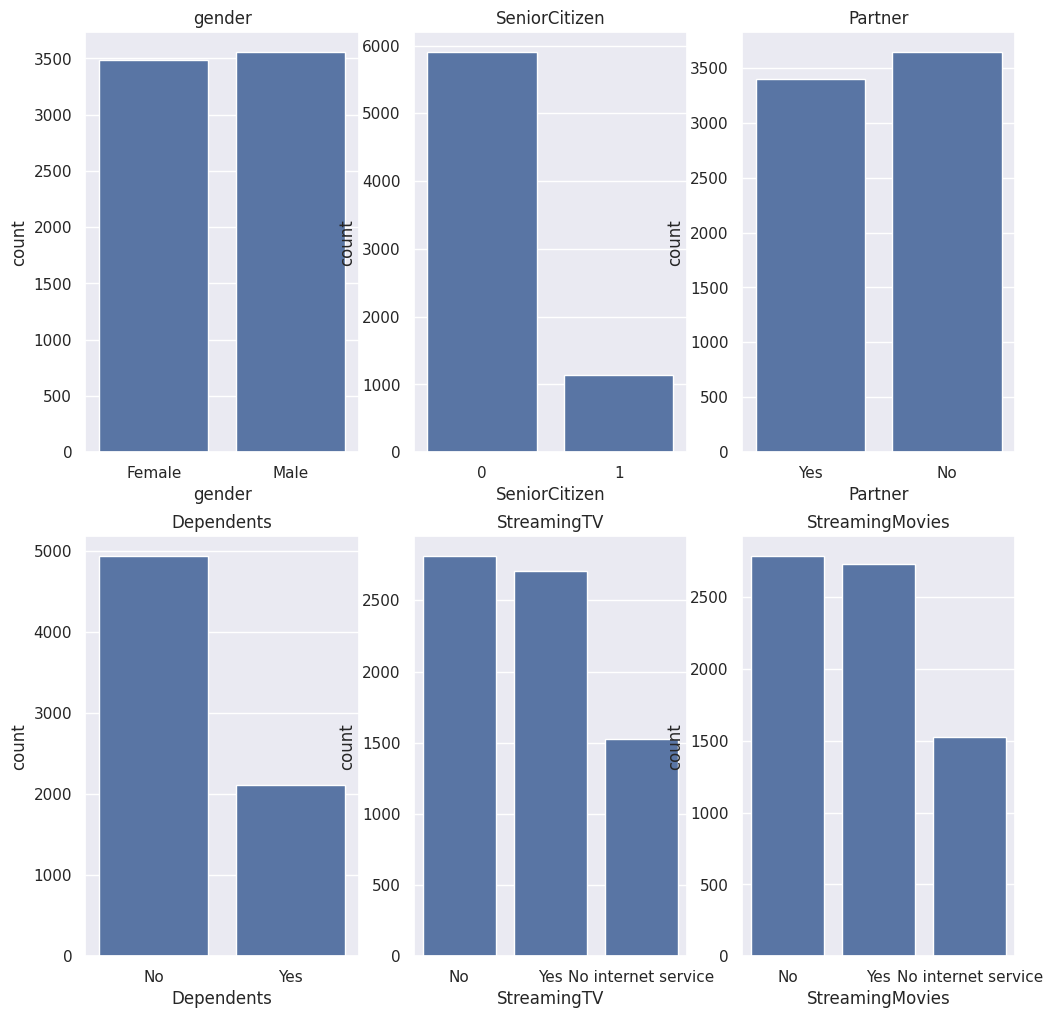

In [9]:
eda_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'StreamingTV', 'StreamingMovies']
numerical = eda_cols

plt.figure(figsize=(12,12))

for i, col in enumerate(numerical):
    ax = plt.subplot(2, int(len(numerical)/2), i+1)
    sns.countplot(x=str(col), data=df)
    ax.set_title(f'{col}')

plt.show()

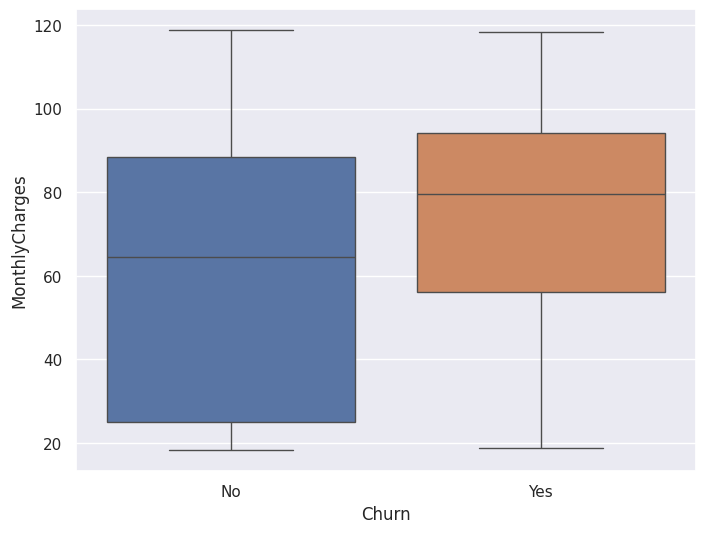

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(df, x='Churn', y='MonthlyCharges', hue='Churn')
plt.show()

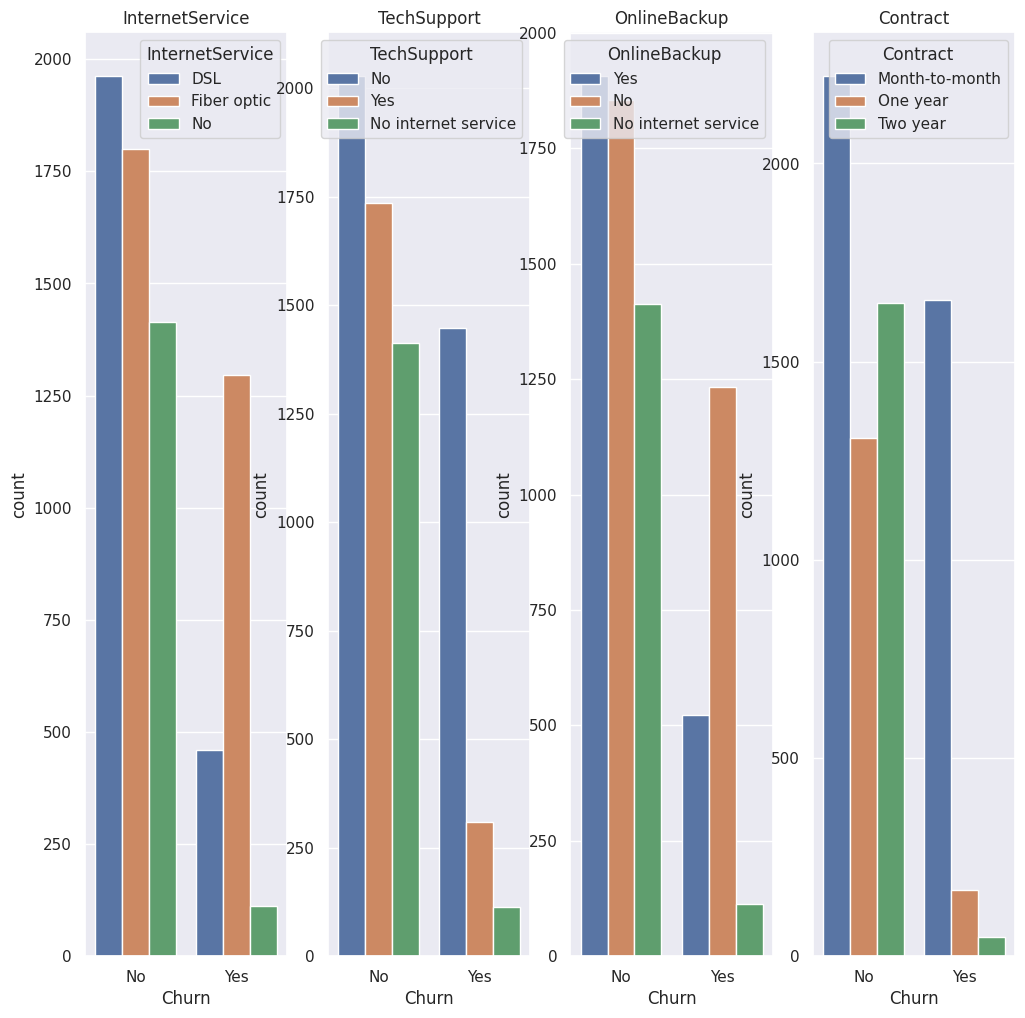

In [11]:
churn_cols = ['InternetService', 'TechSupport', 'OnlineBackup', 'Contract']

plt.figure(figsize=(12,12))

for i, col in enumerate(churn_cols):
    ax = plt.subplot(1, len(churn_cols), i+1)
    sns.countplot(df, x='Churn', hue=str(col))
    ax.set_title(f'{col}')

plt.show()

## Preprocessing Customer Data

### Encoding Categorical Variables

In [12]:
df_num = df.select_dtypes(include='number')
df_cat = df.select_dtypes(exclude='number')

In [13]:
le = LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)

In [14]:
df_cat.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,5375,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,3962,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,2564,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,5535,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,6511,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [15]:
df_final = pd.merge(df_num, df_cat, left_index=True, right_index=True)
df_final = df_final.drop(['customerID'], axis=1)
df_final.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,29.85,29.85,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,0,2,53.85,108.15,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,0,45,42.30,1840.75,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


## Building Classification Models
### RandomForestClassifier & XGBoostClassifier

### RandomForestClassifier

In [16]:
df_final = df_final.dropna()
df_final.isna().sum()

SeniorCitizen       0
tenure              0
MonthlyCharges      0
TotalCharges        0
gender              0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Churn               0
dtype: int64

In [17]:
X = df_final.drop(['Churn'], axis=1)
y = df_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

over_sample = SMOTE(k_neighbors=5)
X_smote, y_smote = over_sample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote

print(y_train.value_counts())

Churn
0    3452
1    3452
Name: count, dtype: int64


In [18]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
cnt_misclass = (y_test != y_pred).sum()

print(f'Misclassified Samples: {cnt_misclass}')
print('Accuracy Score: ', accuracy_score(y_test, y_pred))

Misclassified Samples: 541
Accuracy Score:  0.7669108143041792


### Graphing Feature Importance

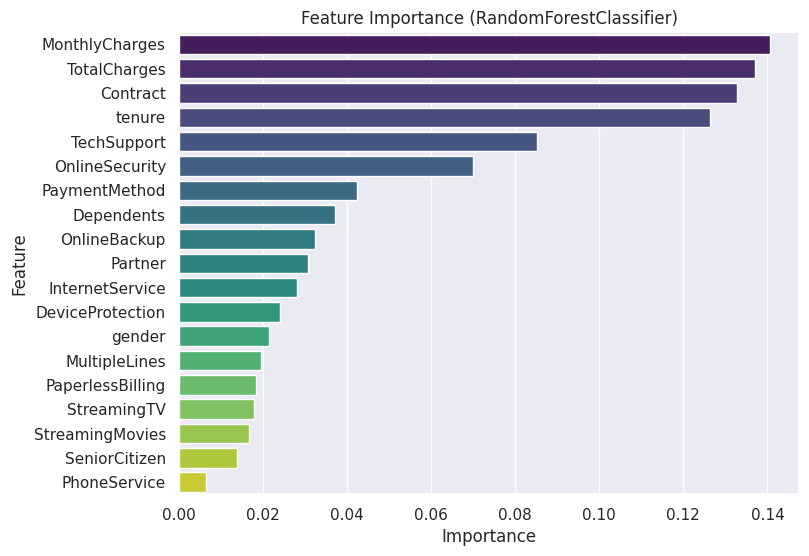

In [19]:
rf_feat_import = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
rf_feat_import = rf_feat_import.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=rf_feat_import, palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance (RandomForestClassifier)')

plt.show()

In [20]:
print('Classification Report: \n', classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1711
           1       0.55      0.58      0.56       610

    accuracy                           0.77      2321
   macro avg       0.70      0.71      0.70      2321
weighted avg       0.77      0.77      0.77      2321



### Graphing Confusion Matrix

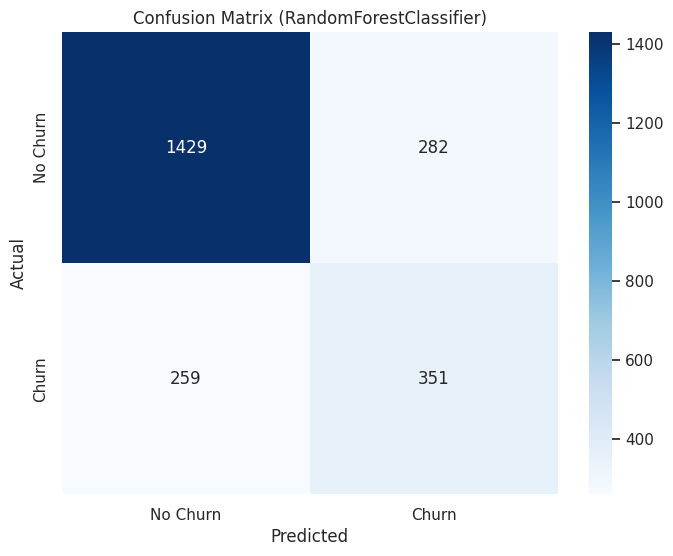

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (RandomForestClassifier)')

plt.show()

## XGBoostClassifier

In [24]:
params = {
    'n_estimators': 21,
    'learning_rate': 0.2,
    'max_depth': 3,
    'gamma': 0.8,
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.65,
    'colsample_bynode': 0.875
}

In [35]:
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train, y_train)

y_pred_2 = xgb_clf.predict(X_test)
cnt_misclass_2 = (y_test != y_pred_2).sum()

print(f'Misclassified Samples: {cnt_misclass_2}')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_2))

Misclassified Samples: 592
Accuracy Score:  0.7449375269280483


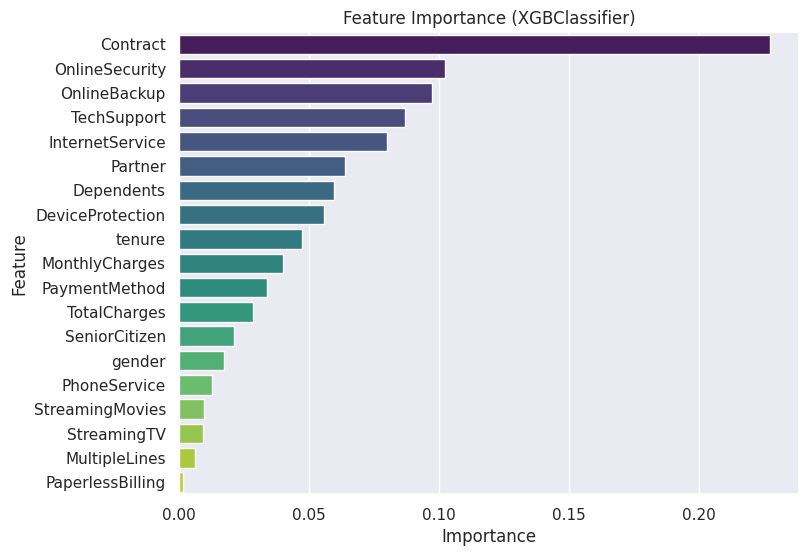

In [36]:
xgb_feat_import = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_clf.feature_importances_
})
xgb_feat_import = xgb_feat_import.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=xgb_feat_import, palette='viridis', hue='Feature', legend=False)
plt.title('Feature Importance (XGBClassifier)')

plt.show()

In [37]:
print('Classification Report: \n', classification_report(y_test, y_pred_2))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      1711
           1       0.51      0.71      0.59       610

    accuracy                           0.74      2321
   macro avg       0.70      0.73      0.70      2321
weighted avg       0.78      0.74      0.76      2321



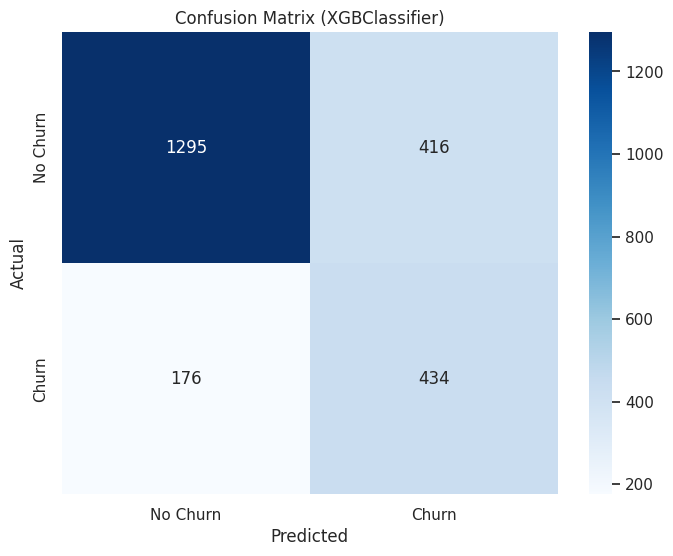

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_2), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBClassifier)')

plt.show()